<a href="https://colab.research.google.com/github/vikas-hkk/Lild4o0d8/blob/main/Genomics(DL%26ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded 133885 molecules


Failed to patch pandas - unable to change molecule rendering


After RDKit parsing: 133885 valid molecules
Computing features...

Train size: 107108, Test size: 26777

Training Random Forest...

Random Forest Performance:
Test MAE: 0.6859
Test MSE: 0.8171
Test R²: 0.9512
Explained Variance: 0.9512


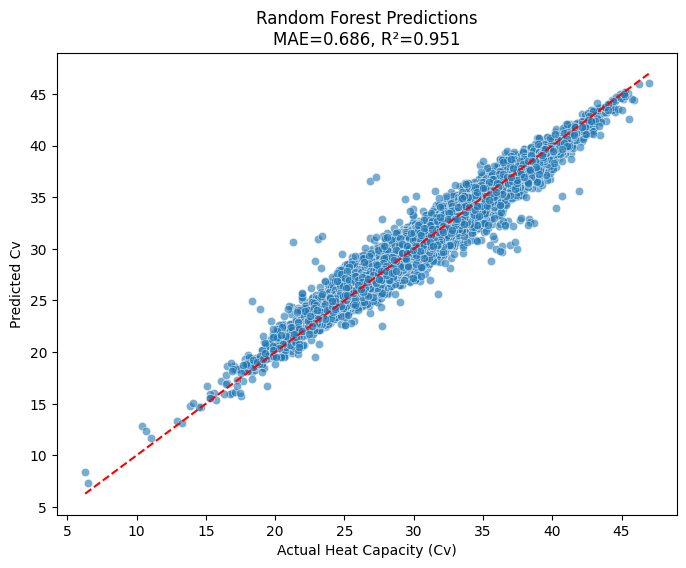


Training XGBoost...

XGBoost Performance:
Test MAE: 0.5363
Test MSE: 0.5101
Test R²: 0.9695
Explained Variance: 0.9695


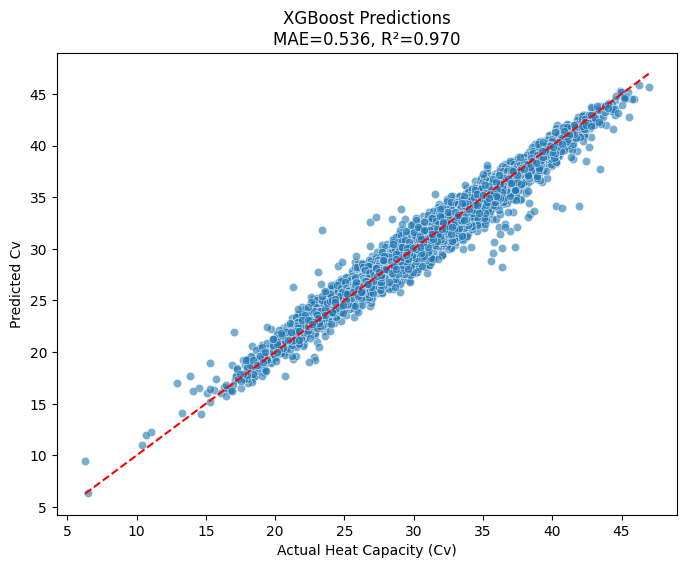


Training LightGBM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 107108, number of used features: 264
[LightGBM] [Info] Start training from score 31.600608


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Performance:
Test MAE: 0.5719
Test MSE: 0.5749
Test R²: 0.9657
Explained Variance: 0.9657


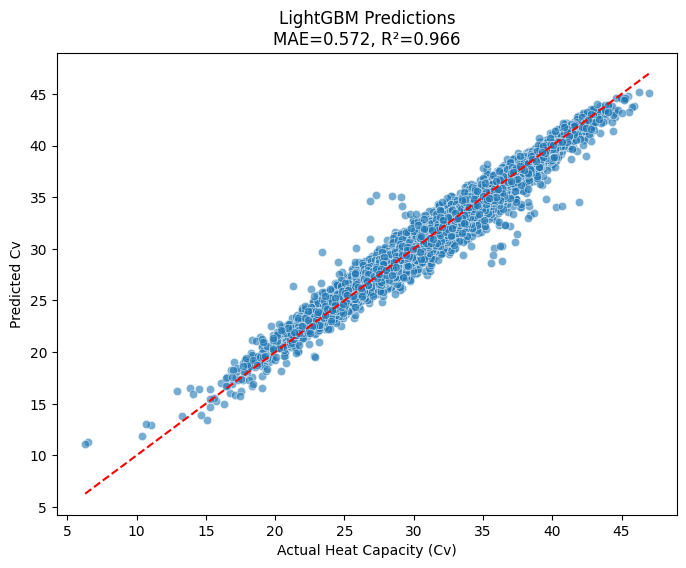

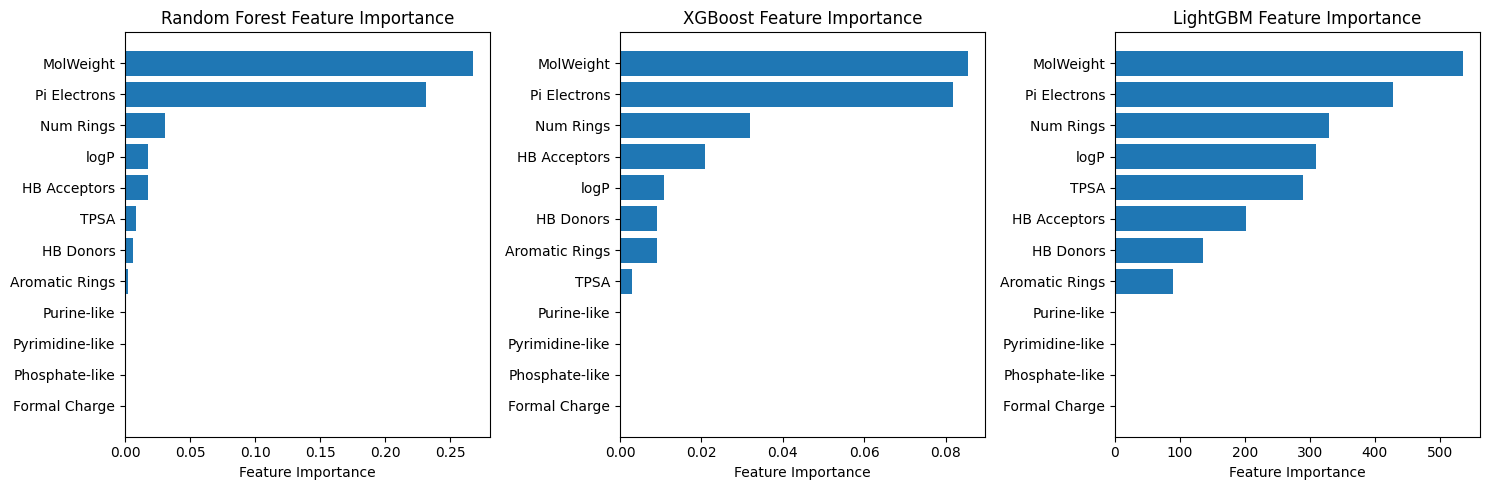

Predicted Cv using Random Forest for C1=CC(=CC=C1C(=O)O)N: 27.635


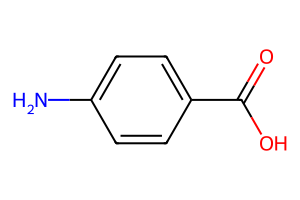

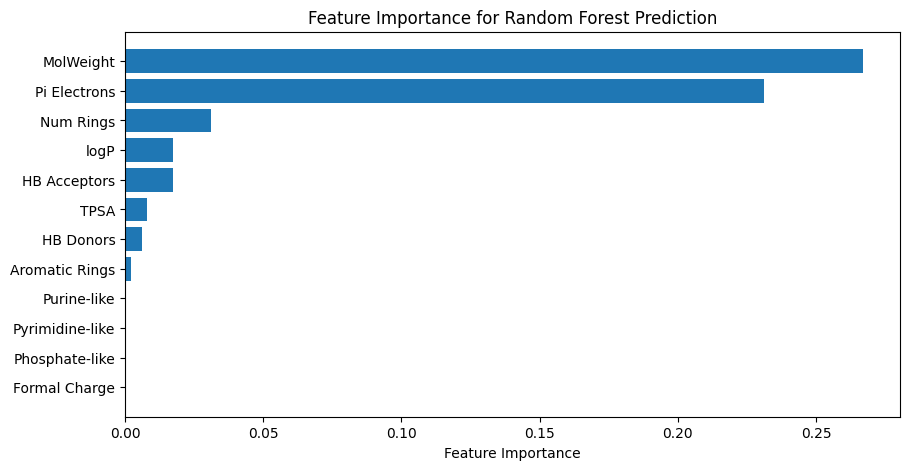

Predicted Cv using XGBoost for C1=CC(=CC=C1C(=O)O)N: 28.698


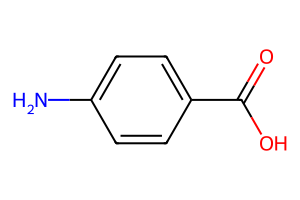

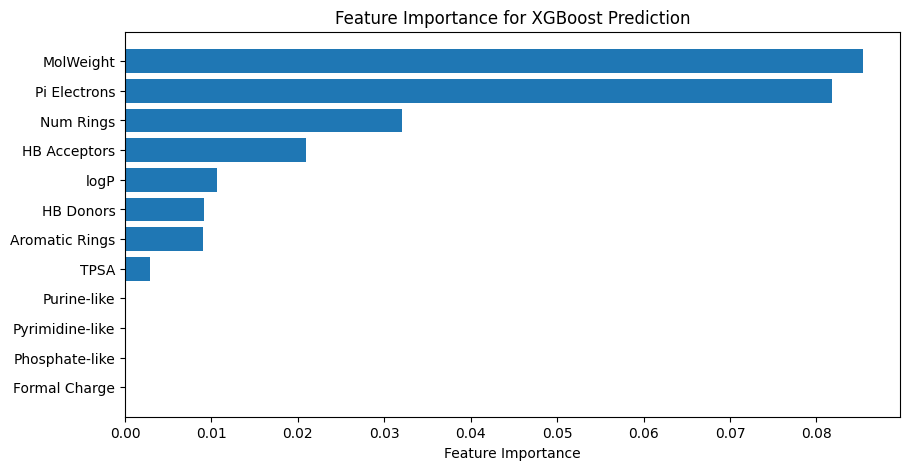

Predicted Cv using LightGBM for C1=CC(=CC=C1C(=O)O)N: 27.199


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


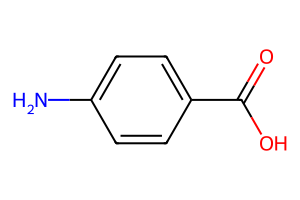

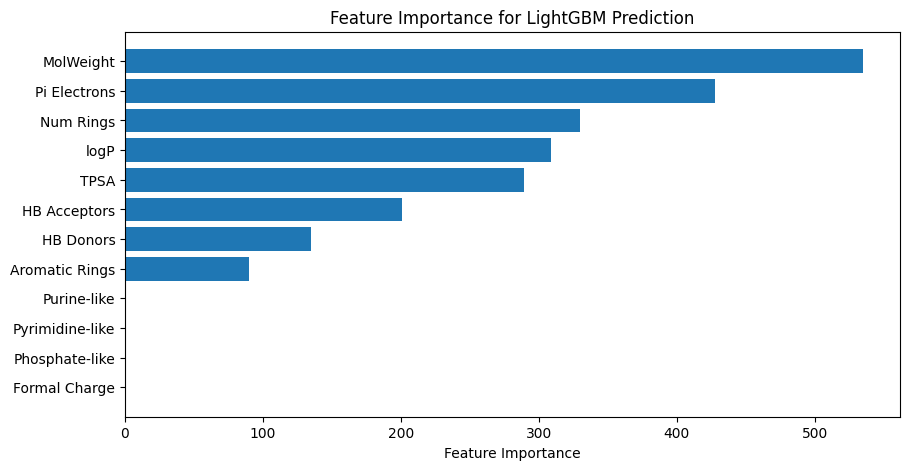

np.float64(27.198659547582828)

In [ ]:
# Genomic-Relevant Heat Capacity Prediction with Random Forest, XGBoost, and LightGBM
# Self-contained Google Colab Notebook (Downloads QM9 automatically)

!pip install rdkit-pypi scikit-learn pandas numpy matplotlib seaborn requests xgboost lightgbm

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, AllChem, PandasTools, Draw
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score, max_error
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# --------------------------
# 1. Download and Prepare QM9 Data
# --------------------------

def download_qm9():
    """Download and extract QM9 dataset"""
    print("Downloading QM9 dataset...")
    url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
    response = requests.get(url)
    df = pd.read_csv(io.StringIO(response.text))
    df = df[['smiles', 'cv']]  # Heat capacity at 298K
    print(f"Loaded {len(df)} molecules")
    return df

# Download and process data
df = download_qm9()
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'mol')
df = df[~df['mol'].isnull()]
print(f"After RDKit parsing: {len(df)} valid molecules")

# --------------------------
# 2. Feature Engineering
# --------------------------

def compute_morgan_fingerprint(mol, radius=2, n_bits=256):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

def calculate_genomic_features(mol):
    features = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        Lipinski.NumAromaticRings(mol),
        sum(b.GetBondTypeAsDouble() for b in mol.GetBonds()),
        Chem.GetFormalCharge(mol),
        int(mol.HasSubstructMatch(Chem.MolFromSmarts('N1C=NC2=C1N=CN2'))),
        int(mol.HasSubstructMatch(Chem.MolFromSmarts('N1C=CC(=NC1=O)N'))),
        int(mol.HasSubstructMatch(Chem.MolFromSmarts('P(=O)(O)(O)'))),
        len(mol.GetRingInfo().AtomRings())
    ]
    return features

print("Computing features...")
df['morgan_fp'] = df['mol'].apply(compute_morgan_fingerprint)
df['genomic_features'] = df['mol'].apply(calculate_genomic_features)

X_morgan = np.stack(df['morgan_fp'].values)
X_genomic = np.stack(df['genomic_features'].values)
X = np.hstack([X_morgan, X_genomic])
y = df['cv'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# --------------------------
# 3. Model Training
# --------------------------

def train_and_evaluate(model, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Explained Variance: {explained_var:.4f}")

    # Plot predictions
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Heat Capacity (Cv)')
    plt.ylabel('Predicted Cv')
    plt.title(f'{model_name} Predictions\nMAE={mae:.3f}, R²={r2:.3f}')
    plt.show()

    return model

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        min_samples_split=5,
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

trained_models = {}
for name, model in models.items():
    trained_models[name] = train_and_evaluate(model, name)

# --------------------------
# 4. Feature Importance Analysis
# --------------------------

genomic_feature_names = [
    'MolWeight', 'logP', 'TPSA',
    'HB Donors', 'HB Acceptors',
    'Aromatic Rings', 'Pi Electrons',
    'Formal Charge',
    'Purine-like', 'Pyrimidine-like',
    'Phosphate-like',
    'Num Rings'
]

plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(trained_models.items()):
    plt.subplot(1, 3, i+1)

    if name == "Random Forest":
        importances = model.feature_importances_[-len(genomic_feature_names):]
    elif name == "XGBoost":
        importances = model.feature_importances_[-len(genomic_feature_names):]
    elif name == "LightGBM":
        importances = model.feature_importances_[len(X_morgan[0]):]  # Corrected array slicing

    sorted_idx = np.argsort(importances)[::-1]
    plt.barh(np.array(genomic_feature_names)[sorted_idx], importances[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'{name} Feature Importance')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# --------------------------
# 5. Prediction Function
# --------------------------

def predict_cv(smiles, model_name='Random Forest'):
    """Predict Cv for a new SMILES string"""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        print("Invalid SMILES")
        return None

    # Compute features
    fp = compute_morgan_fingerprint(mol)
    genomic = calculate_genomic_features(mol)
    features = np.hstack([fp, genomic])

    # Predict
    model = trained_models.get(model_name)
    if not model:
        print(f"Model {model_name} not found. Available: {list(trained_models.keys())}")
        return None

    pred = model.predict([features])[0]

    # Display
    print(f"Predicted Cv using {model_name} for {smiles}: {pred:.3f}")
    img = Draw.MolToImage(mol, size=(300, 200))
    display(img)

    # Feature importance
    if model_name == "Random Forest":
        importances = model.feature_importances_[-len(genomic_feature_names):]
    elif model_name == "XGBoost":
        importances = model.feature_importances_[-len(genomic_feature_names):]
    elif model_name == "LightGBM":
        importances = model.feature_importances_[len(fp):]

    plt.figure(figsize=(10, 5))
    sorted_idx = np.argsort(importances)[::-1]
    plt.barh(np.array(genomic_feature_names)[sorted_idx], importances[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {model_name} Prediction')
    plt.gca().invert_yaxis()
    plt.show()

    return pred

# Example predictions
predict_cv("C1=CC(=CC=C1C(=O)O)N")  # 4-Aminobenzoic acid with Random Forest
predict_cv("C1=CC(=CC=C1C(=O)O)N", model_name='XGBoost')
predict_cv("C1=CC(=CC=C1C(=O)O)N", model_name='LightGBM')

1. Actual vs Predicted Values


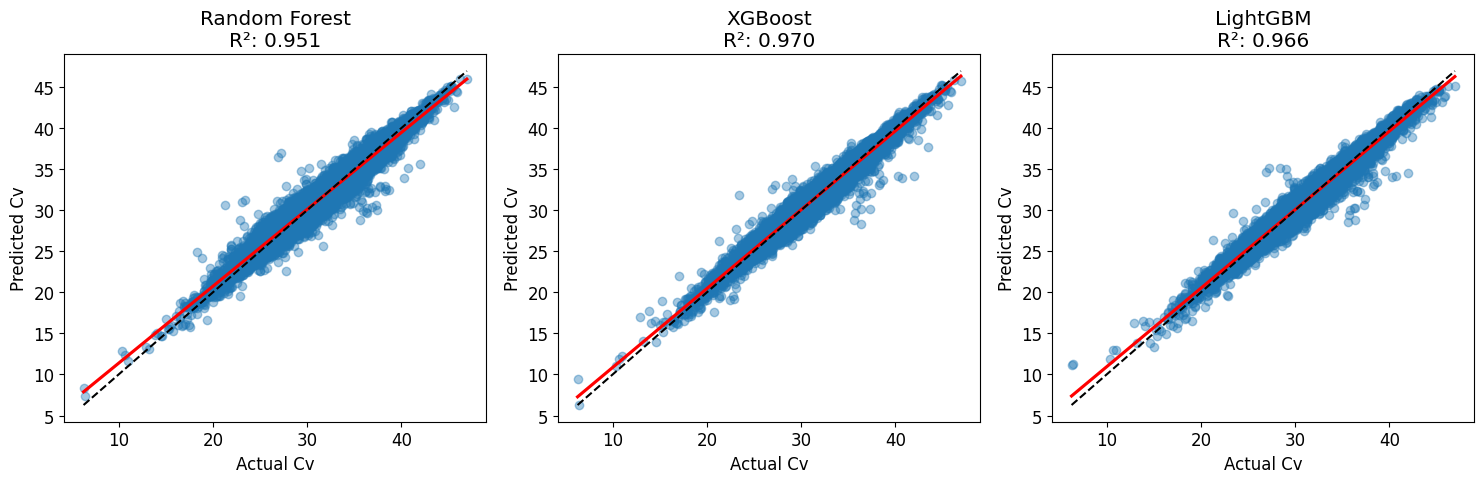


2. Residual Plots


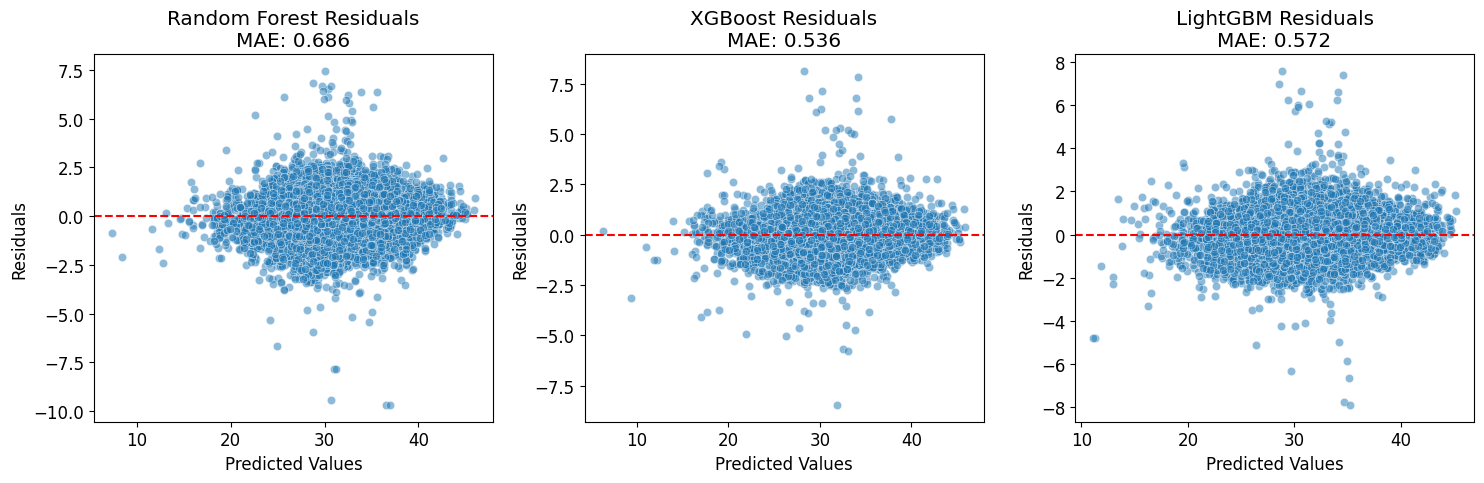


3. Residual Distributions


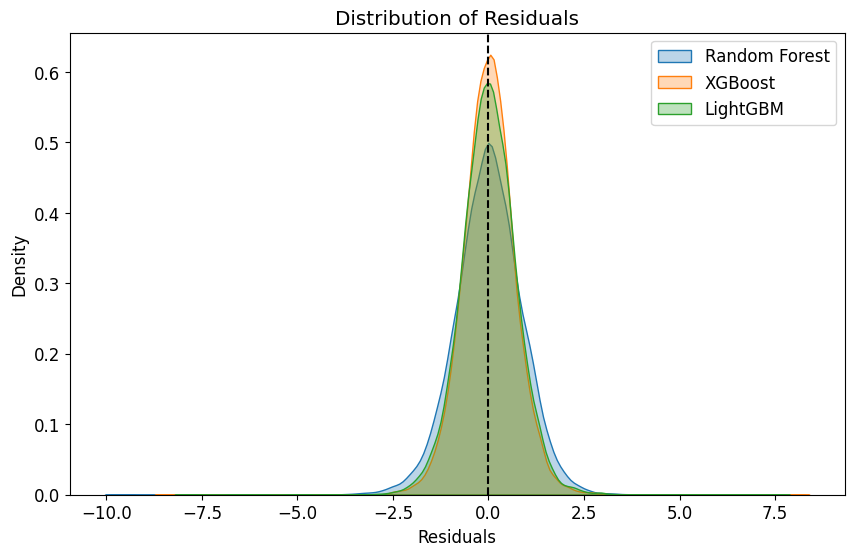


4. Q-Q Plots for Normality Check


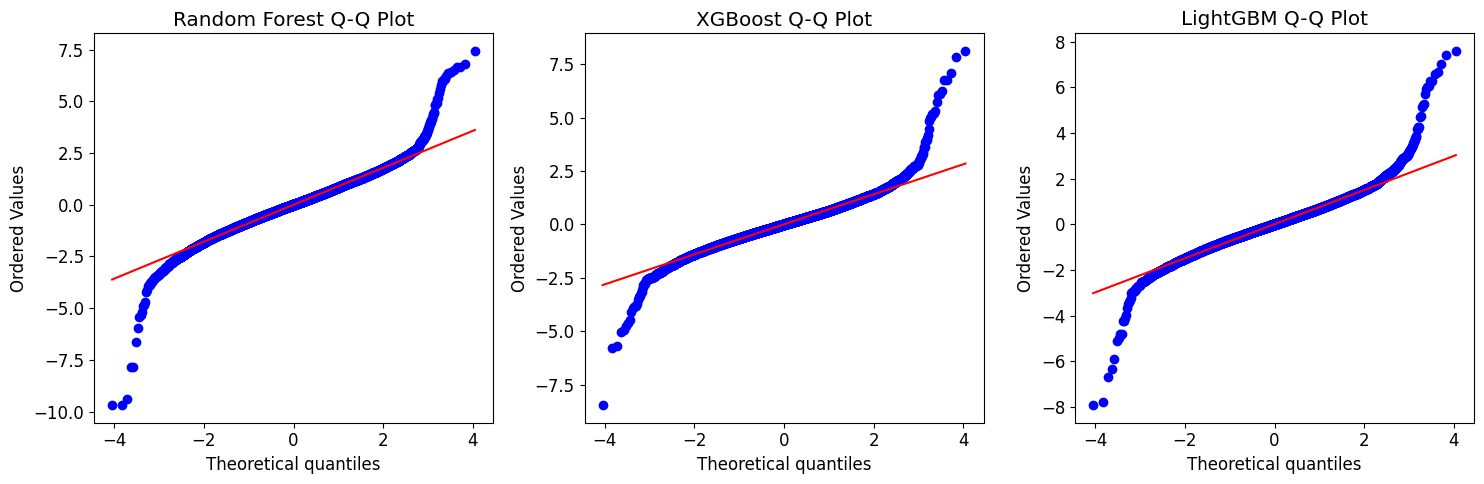


5. Learning Curves
Using subset of 5000 samples for faster computation
Processing Random Forest...
Random Forest completed in 70.9 seconds
Processing XGBoost...


In [ ]:
# --------------------------
# 6. Advanced Model Evaluation Visualizations
# --------------------------

def plot_actual_vs_predicted(models_dict, X_test, y_test):
    """Generate combined actual vs predicted scatter plot for all models"""
    plt.figure(figsize=(15, 5))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(X_test)
        plt.subplot(1, 3, i)
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
        plt.xlabel('Actual Cv')
        plt.ylabel('Predicted Cv')
        plt.title(f'{name}\nR²: {r2_score(y_test, y_pred):.3f}')

    plt.tight_layout()
    plt.show()

def plot_residuals(models_dict, X_test, y_test):
    """Generate residual plots for all models"""
    plt.figure(figsize=(15, 5))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        plt.subplot(1, 3, i)
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'{name} Residuals\nMAE: {mean_absolute_error(y_test, y_pred):.3f}')

    plt.tight_layout()
    plt.show()

def plot_residual_distribution(models_dict, X_test, y_test):
    """Plot distribution of residuals for all models"""
    plt.figure(figsize=(10, 6))

    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        sns.kdeplot(residuals, label=name, fill=True, alpha=0.3)

    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Distribution of Residuals')
    plt.legend()
    plt.show()

def plot_qq(models_dict, X_test, y_test):
    """Generate Q-Q plots for normality check"""
    from scipy import stats

    plt.figure(figsize=(15, 5))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        plt.subplot(1, 3, i)
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f'{name} Q-Q Plot')

    plt.tight_layout()
    plt.show()

def plot_learning_curves(trained_models_dict, X_train, y_train, max_samples=5000, cv=3, n_points=5):
    """
    Generate optimized learning curves using trained models
    """
    from sklearn.model_selection import learning_curve
    import time

    plt.figure(figsize=(15, 5))
    plt.suptitle("Learning Curves (Using Original Models)", y=1.05)

    # Use consistent colors for each model
    colors = {'Random Forest': 'blue', 'XGBoost': 'orange', 'LightGBM': 'green'}

    # Subsample data if too large
    if len(X_train) > max_samples:
        X_sub = X_train[:max_samples]
        y_sub = y_train[:max_samples]
        print(f"Using subset of {max_samples} samples for faster computation")
    else:
        X_sub = X_train
        y_sub = y_train

    train_sizes = np.linspace(0.1, 1.0, n_points)

    for i, (name, model) in enumerate(trained_models_dict.items(), 1):
        start_time = time.time()
        print(f"Processing {name}...")

        original_params = model.get_params()

        if 'verbose' in original_params:
            model.set_params(verbose=0)

        train_sizes, train_scores, val_scores = learning_curve(
            model, X_sub, y_sub,
            cv=cv,
            scoring='neg_mean_absolute_error',
            train_sizes=train_sizes,
            n_jobs=-1
        )

        model.set_params(**original_params)

        plt.subplot(1, 3, i)
        plt.plot(train_sizes, -train_scores.mean(1), 'o-', color=colors.get(name, 'black'), label='Training')
        plt.plot(train_sizes, -val_scores.mean(1), 'o-', color=colors.get(name, 'black'), linestyle='--', label='Validation')
        plt.xlabel('Training Set Size')
        plt.ylabel('MAE')
        plt.title(f'{name}\n(n_estimators={original_params.get("n_estimators", "N/A")})')
        plt.legend()

        print(f"{name} completed in {time.time()-start_time:.1f} seconds")

    plt.tight_layout()
    plt.show()
# Generate all visualizations
print("1. Actual vs Predicted Values")
plot_actual_vs_predicted(trained_models, X_test, y_test)

print("\n2. Residual Plots")
plot_residuals(trained_models, X_test, y_test)

print("\n3. Residual Distributions")
plot_residual_distribution(trained_models, X_test, y_test)

print("\n4. Q-Q Plots for Normality Check")
plot_qq(trained_models, X_test, y_test)

print("\n5. Learning Curves")
plot_learning_curves(trained_models, X_train, y_train)


In [ ]:
# --------------------------
# 6. Advanced Model Evaluation Visualizations
# --------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

def plot_actual_vs_predicted(models_dict, X_test, y_test):
    """Generate combined actual vs predicted scatter plot for all models"""
    plt.figure(figsize=(15, 5))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(X_test)
        plt.subplot(1, 3, i)
        sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{name}\nR²: {r2_score(y_test, y_pred):.3f}')

    plt.tight_layout()
    plt.show()

def plot_residuals(models_dict, X_test, y_test):
    """Generate residual plots for all models"""
    plt.figure(figsize=(15, 5))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        plt.subplot(1, 3, i)
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'{name} Residuals\nMAE: {mean_absolute_error(y_test, y_pred):.3f}')

    plt.tight_layout()
    plt.show()

def plot_residual_distribution(models_dict, X_test, y_test):
    """Plot distribution of residuals for all models"""
    plt.figure(figsize=(10, 6))

    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        sns.kdeplot(residuals, label=name, fill=True, alpha=0.3)

    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Distribution of Residuals')
    plt.legend()
    plt.show()

def plot_qq(models_dict, X_test, y_test):
    """Generate Q-Q plots for normality check"""
    from scipy import stats

    plt.figure(figsize=(15, 5))

    for i, (name, model) in enumerate(models_dict.items(), 1):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        plt.subplot(1, 3, i)
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f'{name} Q-Q Plot')

    plt.tight_layout()
    plt.show()

def plot_learning_curves_optimized(trained_models_dict, X_train, y_train, max_samples=5000, cv=3, n_points=5):
    """
    Generate optimized learning curves using trained models
    """
    from sklearn.model_selection import learning_curve
    import time

    plt.figure(figsize=(15, 5))
    plt.suptitle("Learning Curves (Using Original Models)", y=1.05)

    # Use consistent colors for each model
    colors = {'Random Forest': 'blue', 'XGBoost': 'orange', 'LightGBM': 'green'}

    # Subsample data if too large
    if len(X_train) > max_samples:
        X_sub = X_train[:max_samples]
        y_sub = y_train[:max_samples]
        print(f"Using subset of {max_samples} samples for faster computation")
    else:
        X_sub = X_train
        y_sub = y_train

    train_sizes = np.linspace(0.1, 1.0, n_points)

    for i, (name, model) in enumerate(trained_models_dict.items(), 1):
        start_time = time.time()
        print(f"Processing {name}...")

        original_params = model.get_params()

        if 'verbose' in original_params:
            model.set_params(verbose=0)

        train_sizes, train_scores, val_scores = learning_curve(
            model, X_sub, y_sub,
            cv=cv,
            scoring='neg_mean_absolute_error',
            train_sizes=train_sizes,
            n_jobs=-1
        )

        model.set_params(**original_params)

        plt.subplot(1, 3, i)
        plt.plot(train_sizes, -train_scores.mean(1), 'o-', color=colors.get(name, 'black'), label='Training')
        plt.plot(train_sizes, -val_scores.mean(1), 'o-', color=colors.get(name, 'black'), linestyle='--', label='Validation')
        plt.xlabel('Training Set Size')
        plt.ylabel('MAE')
        plt.title(f'{name}\n(n_estimators={original_params.get("n_estimators", "N/A")})')
        plt.legend()

        print(f"{name} completed in {time.time()-start_time:.1f} seconds")

    plt.tight_layout()
    plt.show()

# Generate all visualizations
print("1. Actual vs Predicted Values")
plot_actual_vs_predicted(trained_models, X_test, y_test)

print("\n2. Residual Plots")
plot_residuals(trained_models, X_test, y_test)

print("\n3. Residual Distributions")
plot_residual_distribution(trained_models, X_test, y_test)

print("\n4. Q-Q Plots for Normality Check")
plot_qq(trained_models, X_test, y_test)

print("\n5. Optimized Learning Curves")
plot_learning_curves_optimized(trained_models, X_train, y_train)
